Skyline- EEG preprocessing script 
--------------------------------------------------

Steps based on the protocol:

Preliminary:
- re-referenced to average reference

Two-steps artefacts rejection:
1. ICA:
    - band pass filter using non-causal 4th order Butterworth filter between 1Hz and 40Hz
    - downsample to 256Hz
    - visual inspection to remove artefacts
    - run ICA and reject eye-movement and muscles activity artefacts
    - save ICA solution on a file
    
2. On a copy of orginal dataset:
    - low pass filter 40Hz
    - apply ICA 

TO DO: get channel location file !!

Imports

In [5]:
import os
import mne
import numpy as np
from mne_bids import make_bids_folders, make_bids_basename
from mne.preprocessing import (ICA,corrmap)

In [2]:
%matplotlib qt

Specify derivatives folder structure


In [74]:
bids_root = '/home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS'
bids_root_der = os.path.join(bids_root, 'derivatives')
if not os.path.exists(bids_root_der):
    os.makedirs(bids_root_der)

preproc_root = os.path.join(bids_root_der, 'eeg_pre_process')
if not os.path.exists(preproc_root):
    os.makedirs(preproc_root)

pv_root = os.path.join(bids_root_der, 'passive_viewing')
if not os.path.exists(pv_root):
    os.makedirs(pv_root)
    
gng_root = os.path.join(bids_root_der, 'go_nogo')
if not os.path.exists(gng_root):
    os.makedirs(gng_root)
    
#create sub folder for pp, sessions

Load data

In [76]:
#
subject_ids=[608]#, 690,429,558,278,148, 276,647,562,477,703,786,726,743,763,507,388,428,375,747,754,279,572,339,667,594,188,545,681,750,330,753,271,295]
sessions=[1]#, 2]

for subj in subject_ids:
    for sess in sessions:
        # creates bids-compatible derivative folderbk
        preproc_path_folder =  make_bids_folders(subject = str(subj), session= str(sess),
                                kind='eeg', bids_root=preproc_root,make_dir=True, overwrite =False)
        
        pv_path_folder =  make_bids_folders(subject = str(subj), session= str(sess),
                                kind='eeg', bids_root=pv_root,make_dir=True, overwrite =False)
        
        gng_path_folder =  make_bids_folders(subject = str(subj), session= str(sess),
                                kind='eeg', bids_root=gng_root,make_dir=True, overwrite =False)
        
        bids_basename = make_bids_basename(subject=str(subj), session=str(sess))
        bids_fname = bids_basename + '_eeg.vhdr'
       
             
        fname = os.path.join(bids_root, 'sub-%d' %subj,  'ses-%d' %sess, 'eeg', bids_fname)

        raw = mne.io.read_raw_brainvision(fname, preload=True)

        events,_ = mne.events_from_annotations(raw)

        events_dict={'go': 11, 'nogo': 13, 'hw': 21, 'neg': 25, 'neut': 22, 'button_press':8, 'fixation':44}  

        # get eletrodes loc
        montage= mne.channels.read_custom_montage(bids_root + '/AC-64.bvef')
        raw.set_montage(montage)
        

Extracting parameters from /home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS/sub-608/ses-1/eeg/sub-608_ses-1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1765639  =      0.000 ...  1765.639 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 25', 'Stimulus/S 44', 'Stimulus/S 50', 'Stimulus/S 55']


<ipython-input-76-959aaef8a4ac>:31: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


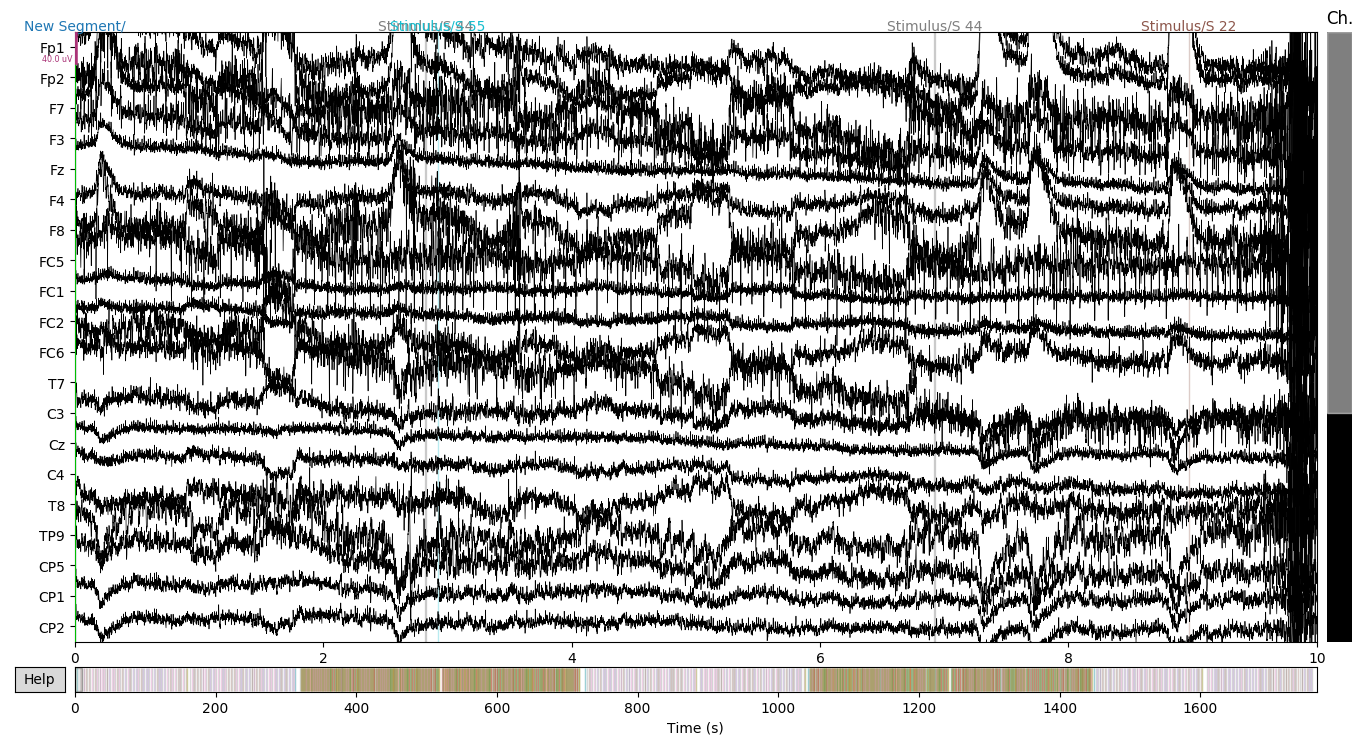

In [5]:
        raw.plot()

Artefact rejection on continuuous data

In [6]:
        # high pass filter data for ICA
        filt_raw =  raw.copy()
        filt_raw.load_data().filter(l_freq=1., h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 sec)



<RawBrainVision  |  sub-608_ses-1_eeg.eeg, n_channels x n_times : 32 x 1765640 (1765.6 sec), ~431.1 MB, data loaded>

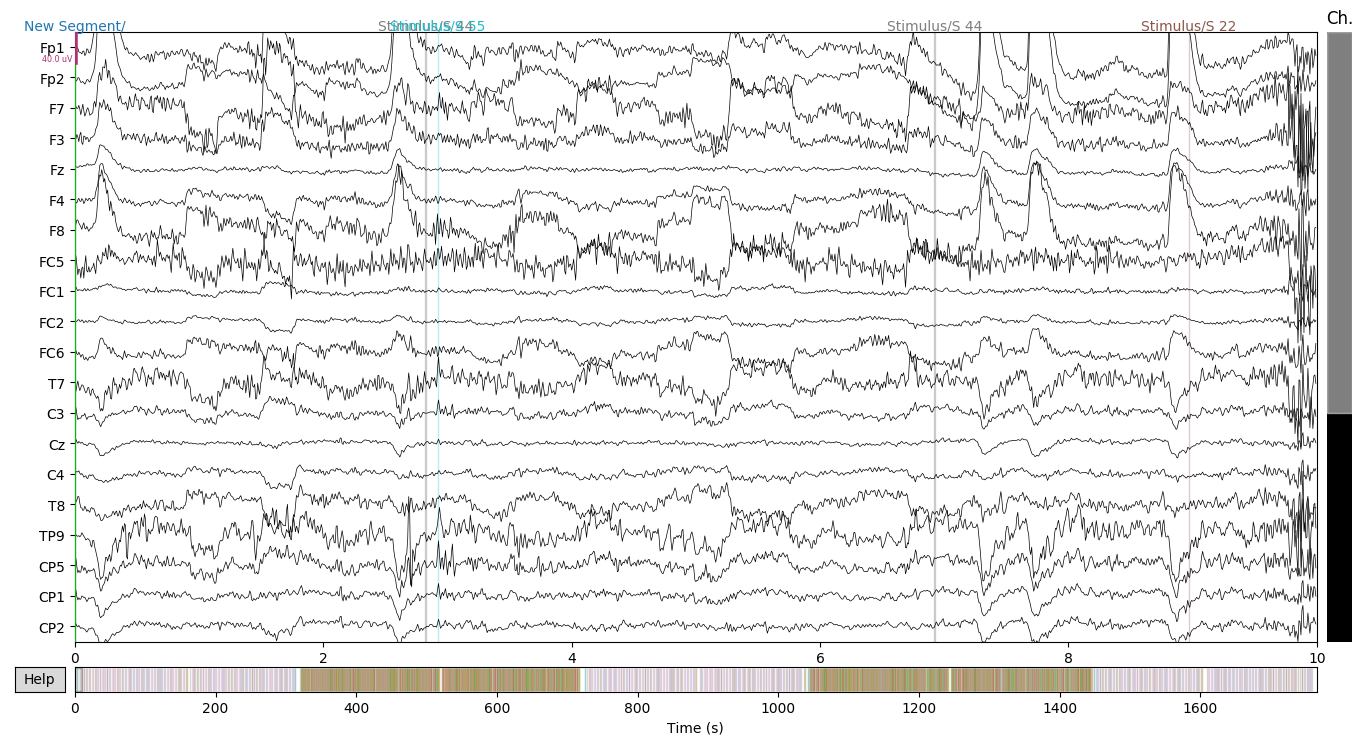

In [10]:
        filt_raw.plot(n_channels=32)

In [46]:
        filt_raw.save(os.path.join( preproc_path_folder,'ica_filter_clean_raw.fif'))

Writing /home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS/derivatives/eeg_pre_process/sub-608/ses-1/eeg/ica_filter_clean_raw.fif
Closing /home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS/derivatives/eeg_pre_process/sub-608/ses-1/eeg/ica_filter_clean_raw.fif [done]


'sub-608_filt_clean_raw.fif'

<ipython-input-18-3629ed2c3e8e>:3: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  filt_raw.set_montage(montage)


<Raw | s608_s01_filt_clean_raw.fif, 32 x 1765640 (1765.6 s), ~431.2 MB, data loaded>

In [8]:
        ica = ICA(n_components=15, random_state=97)
        ica.fit(filt_raw)

Fitting ICA to data using 26 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Omitting 12542 of 1765640 (0.71%) samples, retaining 1753098 (99.29%) samples.
Selecting by number: 15 components
Fitting ICA took 51.7s.


<ICA  |  raw data decomposition, fit (fastica): 1753098 samples, 15 components, channels used: "eeg">

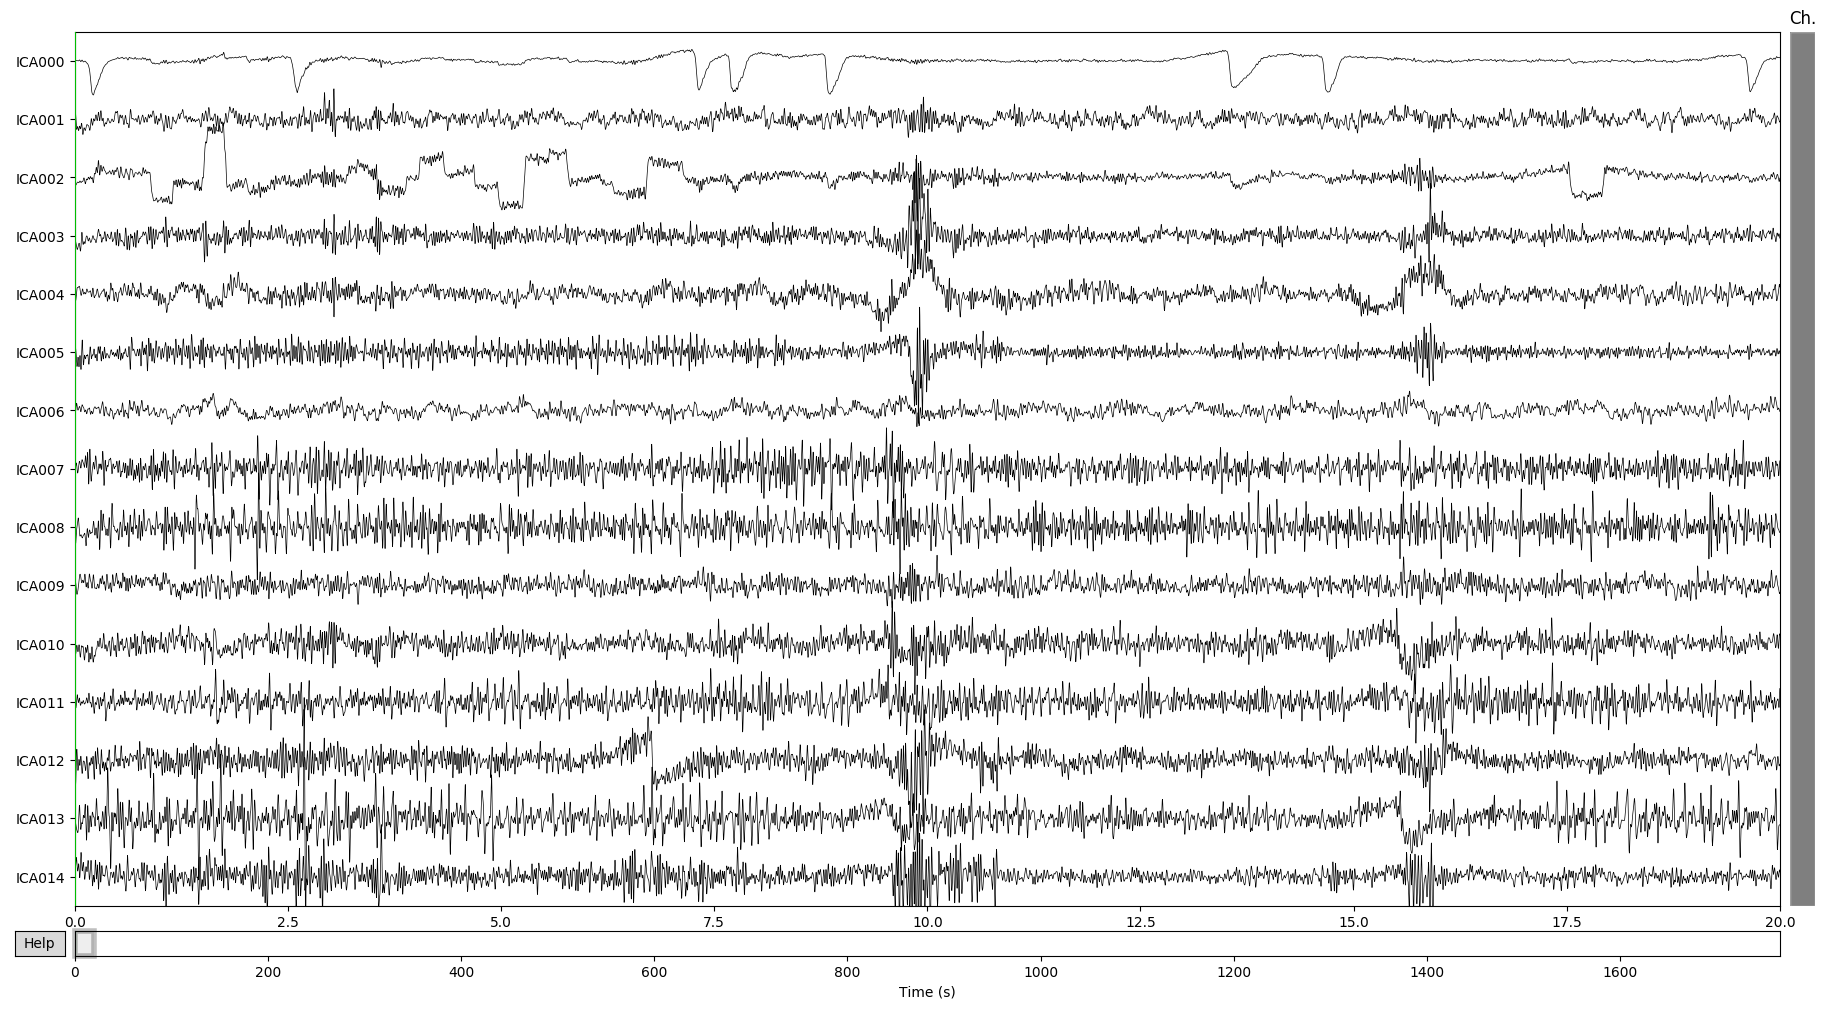

In [10]:
        # select eye movement related components
        ica.plot_sources(filt_raw)
        ica.plot_components()

[<Figure size 975x706.5 with 15 Axes>]

Transforming to ICA space (15 components)
Zeroing out 2 ICA components


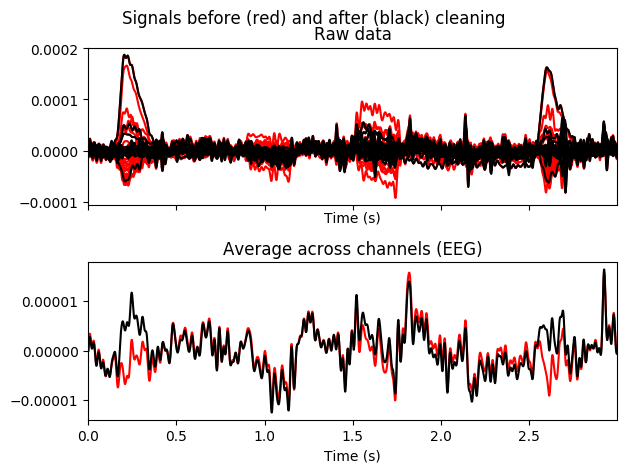

In [19]:
        ica.plot_overlay(filt_raw, exclude=[0, 2], picks='eeg')

IndexError: index 871 is out of bounds for axis 0 with size 871

In [43]:
            ica.exclude=[0,2]
            ica.save(os.path.join( preproc_path_folder,  'weights_ica.fif'))

Writing ICA solution to /home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS/derivatives/eeg_pre_process/sub-608/ses-1/eeg/weights_ica.fif...


<ICA  |  raw data decomposition, fit (fastica): 1753098 samples, 15 components, channels used: "eeg", 2 sources marked for exclusion>

Epoch data
-----------------
1. Get the raw and low filter at 40Hz


2. Passive viewing task timing (in ms): 
    - isi 1500-3000
    - stim pres: 1000-1400
    - in protocol: epoch between -300 and 1000ms
    
3. Go-Nogo task timing (in ms):
    - isi: 500-800
    - stim pres: 600
    - in protocol: epoch between -300 and 600ms

In [39]:
?filter


Filter raw data for ERPs and apply ICA

In [40]:
        # filter data for ERPs
        erp_raw =  raw.copy()
        erp_raw.filter(l_freq=None,h_freq=40, fir_design='firwin') 

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



<RawBrainVision | sub-608_ses-1_eeg.eeg, 32 x 1765640 (1765.6 s), ~431.2 MB, data loaded>

In [66]:
       # fit ICA solution
        ica.apply(erp_raw)

Transforming to ICA space (15 components)
Zeroing out 2 ICA components


<RawBrainVision | sub-608_ses-1_eeg.eeg, 32 x 1765640 (1765.6 s), ~431.2 MB, data loaded>

Reading /home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS/derivatives/eeg_pre_process/sub-608/ses-1/eeg/weights_ica.fif ...
Now restoring ICA solution ...
Ready.


In [63]:
        ica.plot_properties(erp_raw, picks=[0, 2])

    Using multitaper spectrum estimation with 7 DPSS windows
882 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
882 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [77]:
        erp_raw.save(os.path.join( preproc__path_folder, 'erp_filter_raw.fif'))

Writing /home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS/derivatives/passive_viewing/sub-608/ses-1/eeg/erp_filter_raw.fif
Closing /home/claire/Documents/STUDY/EEG-Tobacco/Skyline-EEG-BIDS/derivatives/passive_viewing/sub-608/ses-1/eeg/erp_filter_raw.fif [done]


Epoch passive viewing
---------------------------------


In [69]:
        tmin_pv, tmax_pv = -2, 1
        event_dict_pv = {'hw': 21, 'neg': 25, 'neut': 22}

        epochs_pv = mne.Epochs(erp_raw, events, event_dict_pv, preload=True)

246 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 246 events and 701 original time points ...
0 bad epochs dropped


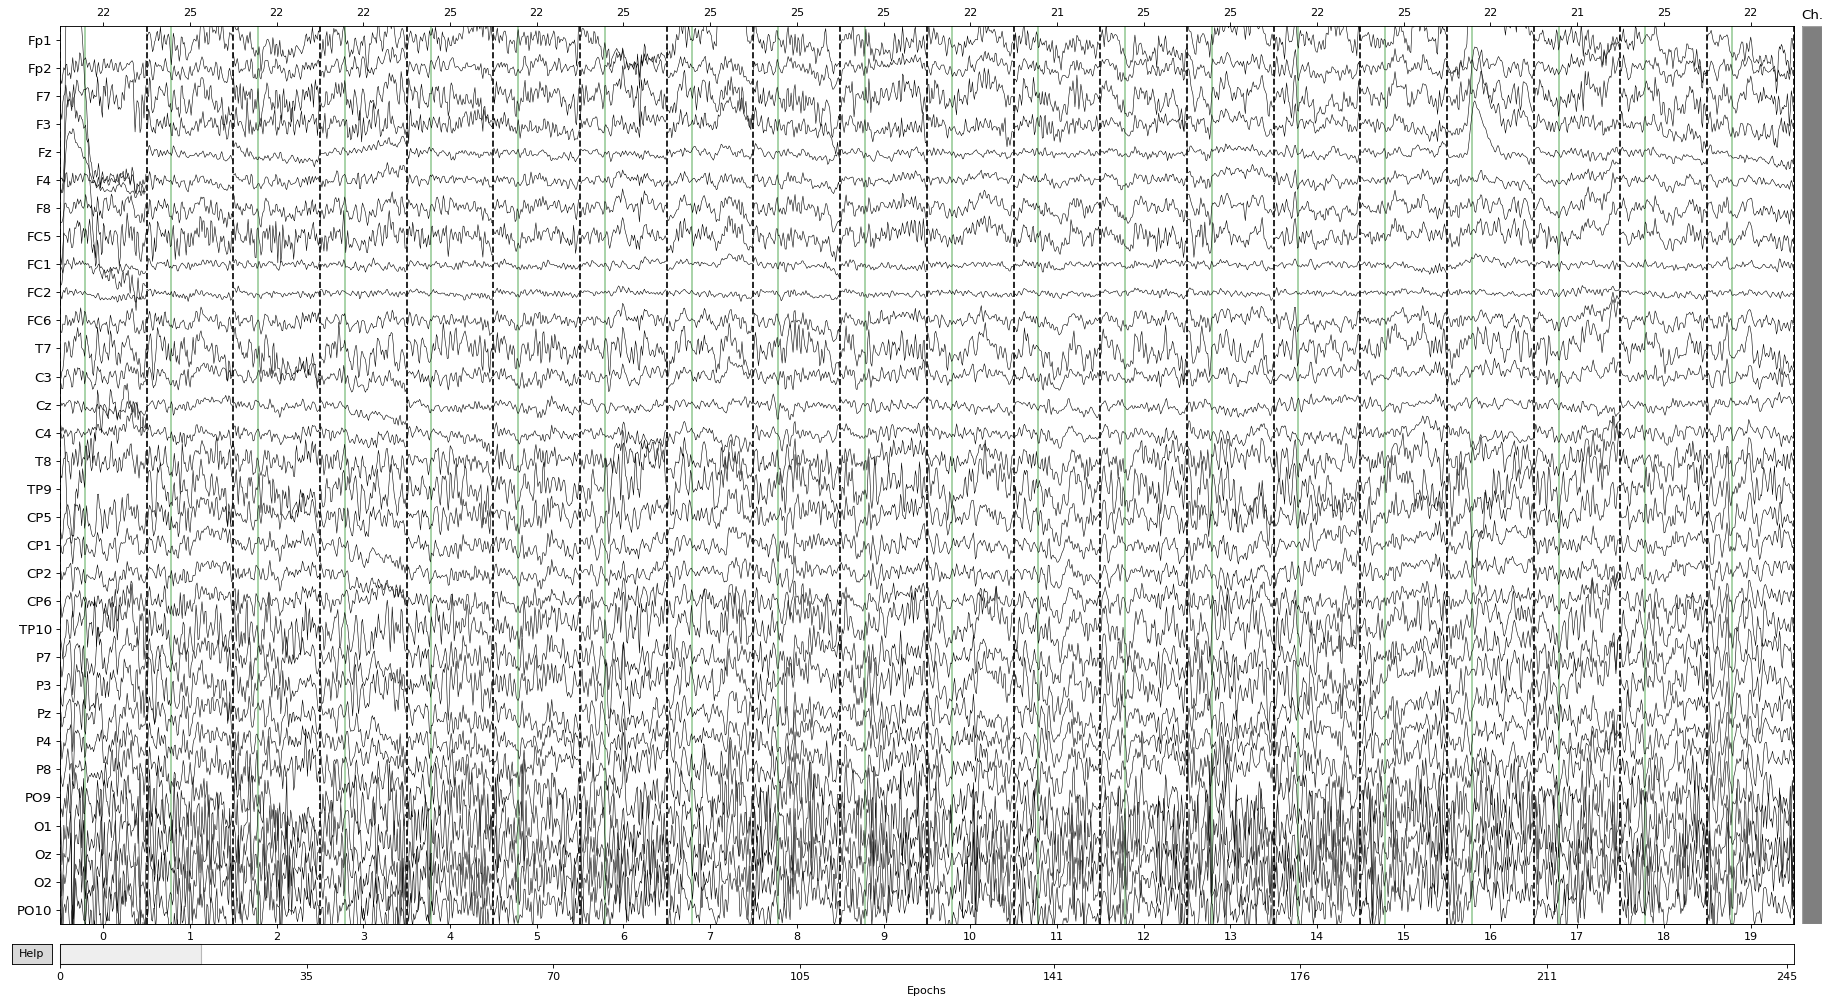

Dropped 3 epochs: 41, 80, 205
Channels marked as bad: []


In [70]:
        epochs_pv.plot(n_channels=32)

In [81]:
            # set average ref after rejection of bad channels
            epochs_pv.set_eeg_reference('average')
            

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Removing existing average EEG reference projection.


<Epochs  |   243 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~41.7 MB, data loaded,
 'hw': 81
 'neg': 80
 'neut': 82>

In [82]:
            epochs_pv.save(os.path.join(pv_path_folder, 'clean_epo.fif'))

In [83]:
            # create average evoked potentials
           # hw, neg, neut = epochs_pv['hw'].average(), epochs_pv['neg'].average(), epochs_pv['neut'].average() 

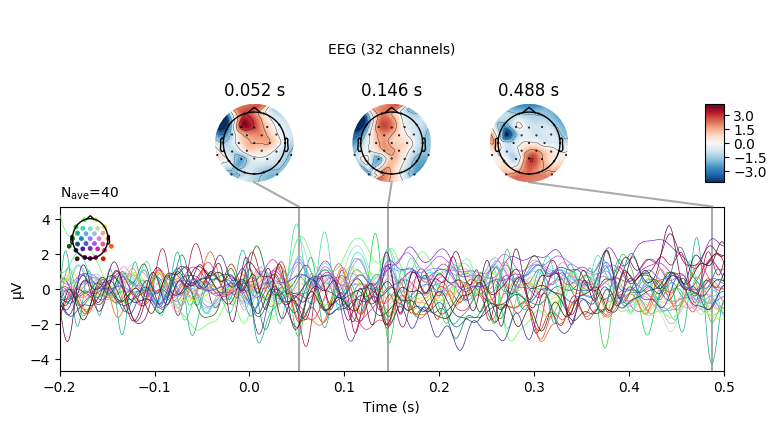

In [86]:
            #mne.combine_evoked([hw, -neut], weights='equal').plot_joint()

Epoch go nogo
-----------------------